data: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) <br>
생존분석


In [1]:
import pandas as pd
from matplotlib import font_manager, rc
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

In [3]:
data_path = '/hdd/data/adp_data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(data_path, index_col = 'customerID')
print(df.shape)
df.head()

(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.loc[(df['tenure'] == 0) & (df['TotalCharges'].isna()), 'TotalCharges'] = 0

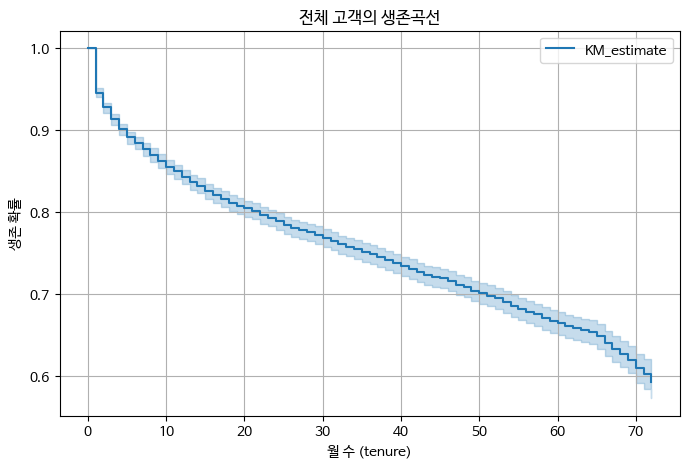

In [5]:
df['Churn_binary'] = df['Churn'].map({'No': 0, 'Yes': 1})

T = df['tenure']
E = df['Churn_binary']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed = E)

plt.figure(figsize = (8, 5))
kmf.plot()
plt.title('전체 고객의 생존곡선')
plt.xlabel('월 수 (tenure)')
plt.ylabel('생존 확률')
plt.grid(True)
plt.show()

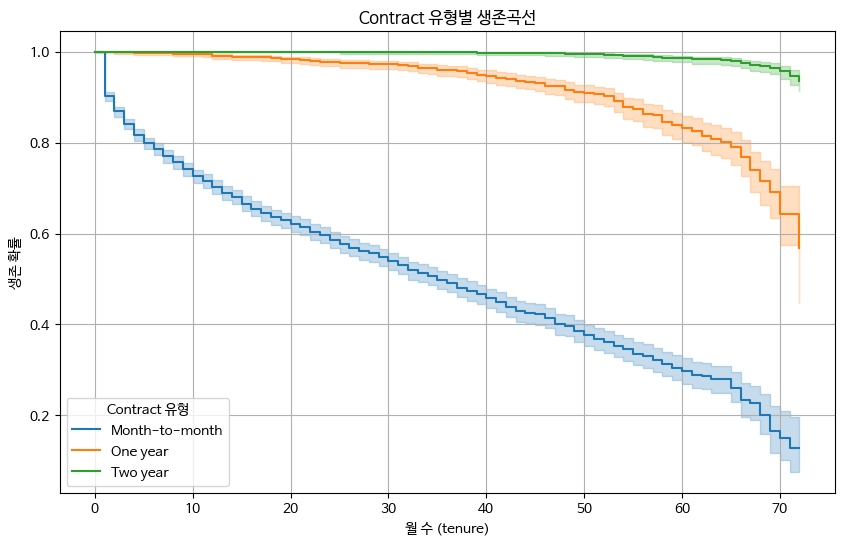

In [6]:
plt.figure(figsize = (10, 6))
kmf = KaplanMeierFitter()

for name, grouped_df in df.groupby('Contract'):
    kmf.fit(grouped_df['tenure'], grouped_df['Churn_binary'], label = name)
    kmf.plot()

plt.title('Contract 유형별 생존곡선')
plt.xlabel('월 수 (tenure)')
plt.ylabel('생존 확률')
plt.grid(True)
plt.legend(title = 'Contract 유형')
plt.show()

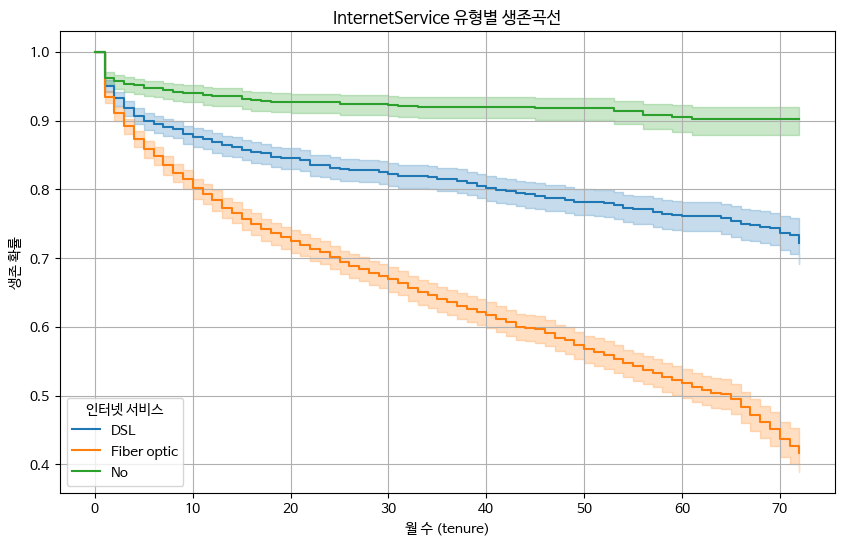

In [7]:
plt.figure(figsize = (10, 6))
kmf = KaplanMeierFitter()

for name, grouped_df in df.groupby('InternetService'):
    kmf.fit(grouped_df['tenure'], grouped_df['Churn_binary'], label = name)
    kmf.plot()

plt.title('InternetService 유형별 생존곡선')
plt.xlabel('월 수 (tenure)')
plt.ylabel('생존 확률')
plt.grid(True)
plt.legend(title = '인터넷 서비스')
plt.show()

귀무가설(H₀): 집단들의 생존 분포가 동일하다. <br>
대립가설(H₁): 집단들의 생존 분포가 다르다.

In [8]:
month_to_month = df[df['Contract'] == 'Month-to-month']
one_year = df[df['Contract'] == 'One year']
two_year = df[df['Contract'] == 'Two year']

result1 = logrank_test(
    month_to_month['tenure'], one_year['tenure'],
    event_observed_A = month_to_month['Churn_binary'],
    event_observed_B = one_year['Churn_binary']
)
print('Month-to-month vs One year:', result1.p_value)

result2 = logrank_test(
    month_to_month['tenure'], two_year['tenure'],
    event_observed_A = month_to_month['Churn_binary'],
    event_observed_B = two_year['Churn_binary']
)
print('Month-to-month vs Two year:', result2.p_value)

result3 = logrank_test(
    one_year['tenure'], two_year['tenure'],
    event_observed_A = one_year['Churn_binary'],
    event_observed_B = two_year['Churn_binary']
)
print('One year vs Two year:', result3.p_value)

Month-to-month vs One year: 2.1173266936004908e-203
Month-to-month vs Two year: 0.0
One year vs Two year: 1.1454483319857575e-57


In [9]:
cols = ['tenure', 'Churn_binary', 'MonthlyCharges', 'TotalCharges', 
        'Contract', 'InternetService', 'TechSupport', 'OnlineSecurity']

df_cox = df[cols].copy()
cat_cols = ['Contract', 'InternetService', 'TechSupport', 'OnlineSecurity']
df_cox = pd.get_dummies(df_cox, columns = cat_cols, drop_first = True)

In [10]:
df_cox.columns

Index(['tenure', 'Churn_binary', 'MonthlyCharges', 'TotalCharges',
       'Contract_One year', 'Contract_Two year', 'InternetService_Fiber optic',
       'InternetService_No', 'TechSupport_No internet service',
       'TechSupport_Yes', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes'],
      dtype='object')

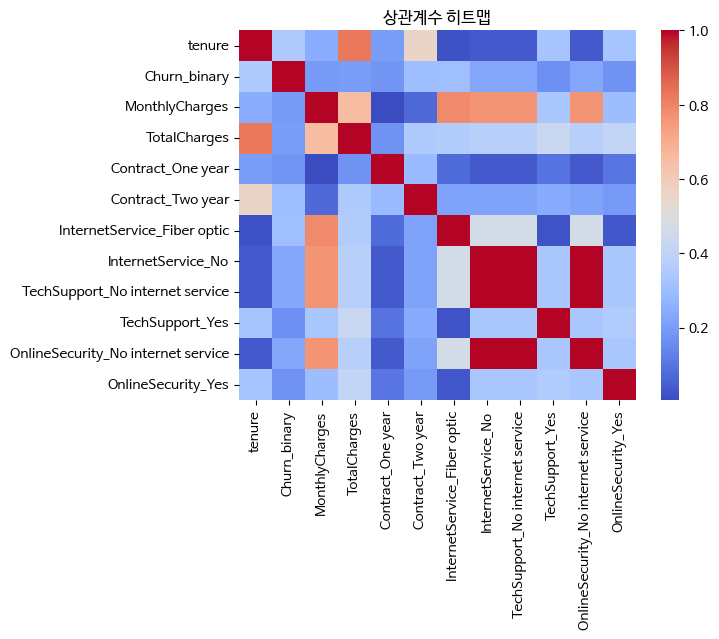

[('InternetService_No', 'TechSupport_No internet service'), ('InternetService_No', 'OnlineSecurity_No internet service'), ('TechSupport_No internet service', 'InternetService_No'), ('TechSupport_No internet service', 'OnlineSecurity_No internet service'), ('OnlineSecurity_No internet service', 'InternetService_No'), ('OnlineSecurity_No internet service', 'TechSupport_No internet service')]


In [11]:
corr_matrix = df_cox.corr().abs()
sns.heatmap(corr_matrix, cmap = 'coolwarm')
plt.title('상관계수 히트맵')
plt.show()

high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > 0.95]
print(high_corr)

In [12]:
drop_cols = [
    'TechSupport_No internet service',
    'OnlineSecurity_No internet service'
]
df_cox = df_cox.drop(columns=drop_cols)

In [13]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col = 'tenure', event_col = 'Churn_binary')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_binary'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12719.44
         time fit was run = 2025-06-04 11:18:40 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
MonthlyCharges               0.04      1.04      0.00            0.04            0.05                1.04                1.05
TotalCharges                -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Contract_One year           -1.33      0.26      0.10           -1.53           -1.14                0.22                0.32
Contract_Two year           -3.83      0.02      0.20           -4.22           -3.43                0.01                0.03
InternetService_Fiber optic  0.45      1.56      0.11            0.24            0.65                1.27                1.92
InternetService_No          -1.48      0.23      0.15           -1.77           -1.19                0.17                0.30
TechSupport_Yes             -0.23      0.79      0.07           -0.36           -0.10                0.70                0.90
OnlineSecurity_Yes          -0.37      0.69      0.07           -0.50           -0.23                0.61                0.79

                             cmp to      z      p  -log2(p)
covariate                                                  
MonthlyCharges                 0.00  16.34 <0.005    196.93
TotalCharges                   0.00 -41.29 <0.005       inf
Contract_One year              0.00 -13.35 <0.005    132.71
Contract_Two year              0.00 -19.08 <0.005    267.26
InternetService_Fiber optic    0.00   4.21 <0.005     15.23
InternetService_No             0.00 -10.05 <0.005     76.55
TechSupport_Yes                0.00  -3.47 <0.005     10.90
OnlineSecurity_Yes             0.00  -5.45 <0.005     24.22
---
Concordance = 0.93
Partial AIC = 25454.88
log-likelihood ratio test = 5867.20 on 8 df
-log2(p) of ll-ratio test = inf

In [14]:
cph = CoxPHFitter()

cph_lasso = CoxPHFitter(penalizer = 0.1, l1_ratio = 1.0)
cph_lasso.fit(df_cox, duration_col = 'tenure', event_col = 'Churn_binary')
cph_lasso.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_binary'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15266.64
         time fit was run = 2025-06-04 11:18:41 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
MonthlyCharges               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
TotalCharges                -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Contract_One year           -0.16      0.85      0.07           -0.29           -0.03                0.75                0.97
Contract_Two year           -0.80      0.45      0.08           -0.97           -0.64                0.38                0.53
InternetService_Fiber optic  0.61      1.83      0.06            0.49            0.73                1.62                2.07
InternetService_No          -0.07      0.93      0.08           -0.22            0.08                0.80                1.08
TechSupport_Yes             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
OnlineSecurity_Yes          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                             cmp to      z      p  -log2(p)
covariate                                                  
MonthlyCharges                 0.00   0.01   0.99      0.01
TotalCharges                   0.00 -16.28 <0.005    195.49
Contract_One year              0.00  -2.46   0.01      6.17
Contract_Two year              0.00  -9.51 <0.005     68.83
InternetService_Fiber optic    0.00   9.82 <0.005     73.25
InternetService_No             0.00  -0.93   0.35      1.50
TechSupport_Yes                0.00  -0.01   0.99      0.01
OnlineSecurity_Yes             0.00  -0.01   0.99      0.01
---
Concordance = 0.93
Partial AIC = 30549.28
log-likelihood ratio test = 772.80 on 8 df
-log2(p) of ll-ratio test = 534.25

In [15]:
scale_cols = ['MonthlyCharges', 'TotalCharges']
df_cox_scaled = df_cox.copy()
df_cox_scaled[scale_cols] = StandardScaler().fit_transform(df_cox[scale_cols])

In [16]:
cph_lasso = CoxPHFitter(penalizer = 0.1, l1_ratio = 1.0)
cph_lasso.fit(df_cox_scaled, duration_col = 'tenure', event_col = 'Churn_binary')
cph_lasso.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_binary'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15266.64
         time fit was run = 2025-06-04 11:18:42 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
MonthlyCharges               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
TotalCharges                -0.67      0.51      0.04           -0.75           -0.59                0.47                0.56
Contract_One year           -0.16      0.85      0.07           -0.29           -0.03                0.75                0.97
Contract_Two year           -0.80      0.45      0.08           -0.97           -0.64                0.38                0.53
InternetService_Fiber optic  0.61      1.83      0.06            0.49            0.73                1.62                2.07
InternetService_No          -0.07      0.93      0.08           -0.22            0.08                0.80                1.08
TechSupport_Yes             -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
OnlineSecurity_Yes          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                             cmp to      z      p  -log2(p)
covariate                                                  
MonthlyCharges                 0.00   0.01   0.99      0.01
TotalCharges                   0.00 -16.28 <0.005    195.49
Contract_One year              0.00  -2.46   0.01      6.17
Contract_Two year              0.00  -9.51 <0.005     68.83
InternetService_Fiber optic    0.00   9.82 <0.005     73.25
InternetService_No             0.00  -0.93   0.35      1.50
TechSupport_Yes                0.00  -0.01   0.99      0.01
OnlineSecurity_Yes             0.00  -0.01   0.99      0.01
---
Concordance = 0.93
Partial AIC = 30549.28
log-likelihood ratio test = 772.80 on 8 df
-log2(p) of ll-ratio test = 534.25

In [17]:
final_cols = ['TotalCharges', 'Contract_One year', 'Contract_Two year', 'InternetService_Fiber optic', 'tenure', 'Churn_binary']
df_cox_scaled = df_cox_scaled[final_cols]

cph_lasso = CoxPHFitter(penalizer = 0.1, l1_ratio = 1.0)
cph_lasso.fit(df_cox_scaled, duration_col = 'tenure', event_col = 'Churn_binary')
cph_lasso.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_binary'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15267.07
         time fit was run = 2025-06-04 11:18:44 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
TotalCharges                -0.65      0.52      0.04           -0.72           -0.58                0.49                0.56
Contract_One year           -0.18      0.84      0.06           -0.30           -0.05                0.74                0.95
Contract_Two year           -0.83      0.44      0.08           -0.98           -0.68                0.37                0.51
InternetService_Fiber optic  0.62      1.85      0.06            0.50            0.74                1.64                2.09

                             cmp to      z      p  -log2(p)
covariate                                                  
TotalCharges                   0.00 -17.78 <0.005    232.49
Contract_One year              0.00  -2.81 <0.005      7.66
Contract_Two year              0.00 -10.78 <0.005     87.62
InternetService_Fiber optic    0.00  10.11 <0.005     77.40
---
Concordance = 0.93
Partial AIC = 30542.14
log-likelihood ratio test = 771.94 on 4 df
-log2(p) of ll-ratio test = 548.24

- Concordance = 0.93
→ 모델 예측이 실제 생존/사건 순서와 잘 맞음 (높을수록 좋음, 0.5는 랜덤)

- Partial AIC = 30542.14
→ 다른 모델과 비교할 때 상대적 지표, 낮을수록 좋음

- Log-likelihood ratio test = 771.94 (df=4, p 매우 작음)
→ 모델 전체가 통계적으로 유의함

In [18]:
cph_lasso.check_assumptions(df_cox_scaled, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic      p  -log2(p)
Contract_One year           km              0.50   0.48      1.05
                            rank            1.55   0.21      2.23
Contract_Two year           km             99.52 <0.005     75.44
                            rank           82.43 <0.005     62.98
InternetService_Fiber optic km              0.34   0.56      0.84
                            rank            1.49   0.22      2.17
TotalCharges                km            224.63 <0.005    166.28
                            rank          140.09 <0.005    104.96



1. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Contract_Two year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_Two year', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%

[]

`check_assumptions`는 비례 위험 가정(proportional hazards assumption) 위반 여부를 검증<br>
TotalCharges, Contract_Two year	비례 위험 가정 위반.<br>
TotalCharges는 비선형 변환(로그, 다항식), 구간화 후 strata 적용 또는 시간과의 상호작용항을 추가<br>
Contract_Two year는 이진 변수이므로 strata로 층화하여 각 그룹별로 베이스라인 위험을 다르게 추정할 수 있음.<br>
`strata`옵션은 Cox 모델에 변수별 baseline hazard 함수를 다르게 적용하는 기능

In [19]:
df_cox_scaled['TotalCharges_bin'] = pd.qcut(df_cox_scaled['TotalCharges'], q = 4, labels = False)
df_cox_scaled = df_cox_scaled.drop(columns = ['TotalCharges'])

cph_stratified = CoxPHFitter(penalizer = 0.1, l1_ratio = 1.0)
cph_stratified.fit(df_cox_scaled, duration_col = 'tenure', event_col = 'Churn_binary', strata = ['TotalCharges_bin', 'Contract_Two year'])
cph_stratified.print_summary()

model,lifelines.CoxPHFitter
duration col,'tenure'
event col,'Churn_binary'
penalizer,0.1
l1 ratio,1.0
strata,"[TotalCharges_bin, Contract_Two year]"
baseline estimation,breslow
number of observations,7043
number of events observed,1869
partial log-likelihood,-12303.08
time fit was run,2025-06-04 11:18:45 UTC



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/lifelines/fitters/mixins.py:154: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic      p  -log2(p)
Contract_One year           km             21.75 <0.005     18.30
                            rank           22.23 <0.005     18.66
InternetService_Fiber optic km              2.18   0.14      2.84
                            rank            1.38   0.24      2.06



1. Variable 'Contract_One year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/lifelines/fitters/mixins.py:154: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()


[[<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2405)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1400)'>]]

/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  func(*args, **kwargs)
/home/ubuntu/work_space/adp_hands_on/.adp_hands_on/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


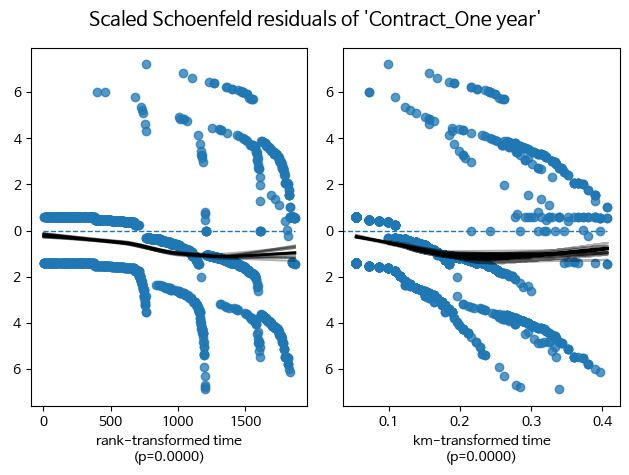

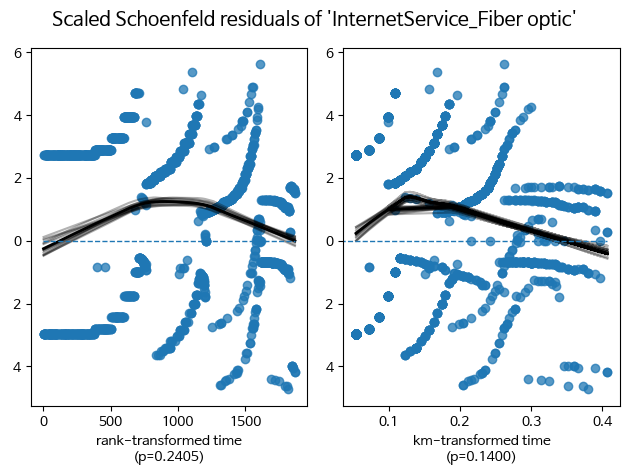

In [20]:
cph_stratified.check_assumptions(df_cox_scaled, show_plots=True)